In [1]:
from torchvision import transforms, datasets
import os
import glob
from random import shuffle
import torch
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
import scipy.io as scio
from func import basic,visualization
import numpy as np
import pandas as pd

/home/wangyh/miniconda3/envs/patho_AI/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 以5x做单折测试 -- 旧 混合版

## 分配数据集

In [171]:
data_5x = glob.glob('/mnt/wangyh/CN_patches/*/*/5X/T*')
# set of 5x tumor tiles, has a length of 28277

In [21]:
# 5折交叉
size_val = len(data_5x)//5
# size_train = len(data_5x)- size_val

shuffle(data_5x)
val = data_5x[:size_val]
train = data_5x[size_val:]

In [ ]:
IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm']

In [39]:
def myData(args):
# data_transform, pay attention that the input of Normalize() is Tensor and the input of RandomResizedCrop() or RandomHorizontalFlip() is PIL Image
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    image_datasets = {}
    #image_datasets['train'] = datasets.ImageFolder(os.path.join(args.data_dir, 'ILSVRC2012_img_train'), data_transforms['train'])

    image_datasets['train'] = myDataSet(train,data_transforms=data_transforms['train'])
    image_datasets['val'] = myDataSet(val,data_transforms=data_transforms['val'])

    # wrap your data and label into Tensor
    dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                 batch_size=args.batch_size,
                                                 shuffle=True,
                                                 num_workers=args.num_workers) for x in ['train', 'val']}


    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    return dataloders, dataset_sizes

class myDataSet(torch.utils.data.Dataset):
    def __init__(self, img_list,label,data_transforms = None):
        label_dic = {
            'H':0,
            'L':1
        }
        self.img_list = img_list
        self.label_dic = label_dic
        self.label = label
        self.data_transforms = data_transforms
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        label_dic = {
            'H':0,
            'L':1
        }
        item = self.img_list[index]
        img = Image.open(item)
        if self.data_transforms is not None:
            try:
                img = self.data_transforms(img)
            except:
                print("Cannot transform image: {}".format(self.img_list[index]))
        label = label_dic[self.label]
        return img, label

# 对5x数据集，resnext表现评估

In [89]:
loss = np.load("./resnext/output/lossdata.npy",allow_pickle= True).item()

In [94]:
acc = np.load('./resnext/output/accdata.npy',allow_pickle=True).item()

In [121]:
df_loss = pd.DataFrame(loss)

In [ ]:
for x in ['train','val']:
    acc[x] = [i.cpu() for i in acc[x]]

In [115]:
df_acc = pd.DataFrame(acc)

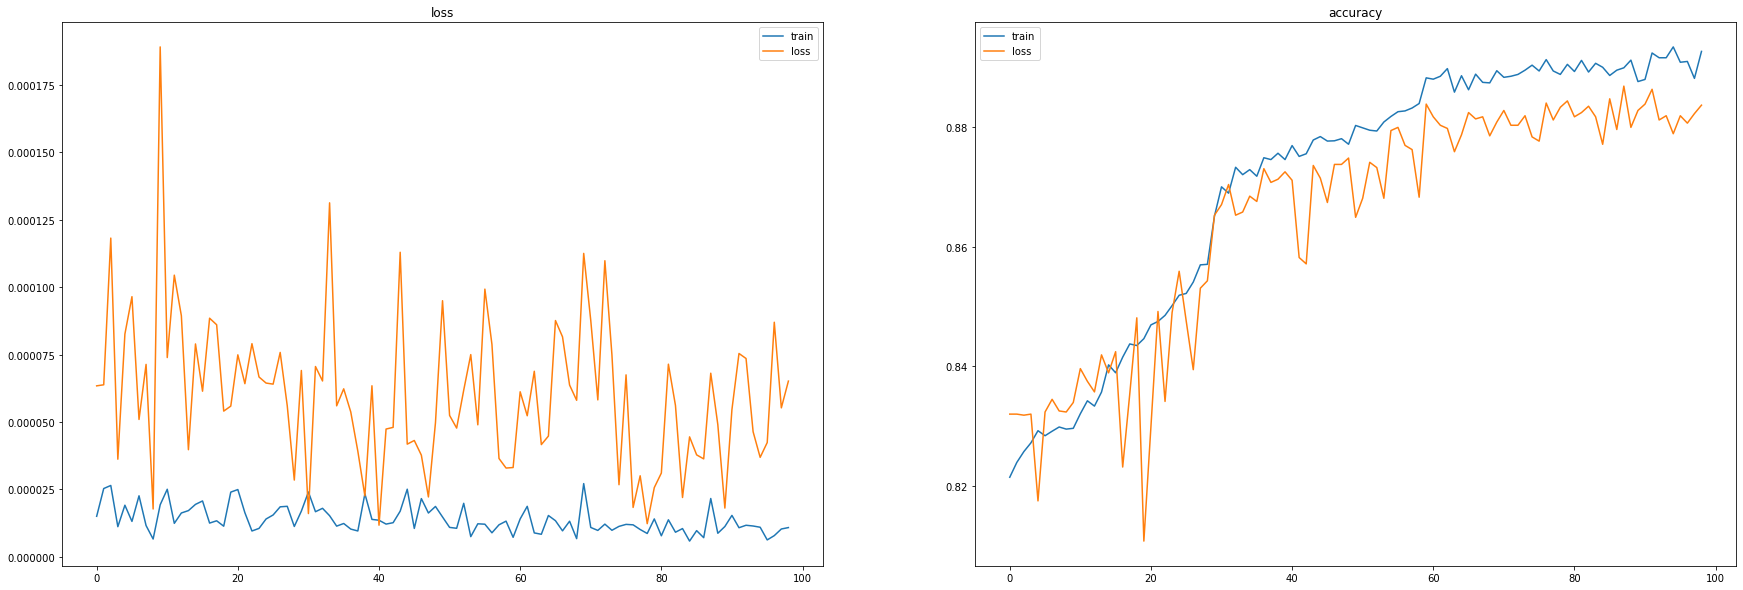

In [130]:
fig,axes = plt.subplots(1,2,figsize = (30,10))
ax1 = axes[0]
ax1.set_title('loss')
ax1.plot(df_loss['train'],label = 'train')
ax1.plot(df_loss['val'],label = 'loss')
ax1.legend()


ax2 = axes[1]
ax2.set_title('accuracy')
ax2.plot(df_acc['train'],label = 'train')
ax2.plot(df_acc['val'],label = 'loss')
ax2.legend()

# 用内部数据自己做一下验证

在resnext文件夹里面进行验证，不在该文件夹会报namespace错误：

AttributeError: Can't get attribute 'ResNeXt' on <module 'resnext' (namespace)>

# 以5x做测试 -- 新 patient balance版

In [2]:
class dataset_reform():
    def __init__(self,dataset):
        ''' 
        args:
            dataset:path of a npy file,containing a dict, arranged in form:
                {'train_list':<a dataframe>,
                'val_list':<a dataframe>,
                'test_list':<a dataframe>
                },
            formed in dataset segmentation.ipynb
        '''
        data = np.load(dataset,allow_pickle=True).item()

        self.training = data['train_list']
        self.val = data['val_list']
        self.testing = data['test_list']

        self.training_count = self.__get_patches_count(self.training)
        self.val_count = self.__get_patches_count(self.val)
        self.testing_count = self.__get_patches_count(self.testing)
    
    def __get_patches_count(self,data):
        '''
        args:
            data:['self.training','self.val','self.testing']
        returns:
            a list of patches count in each list
        '''
        return data.iloc[:,2]

    def __get_patches_count_with_label(self,data):
        '''
        H/L in each dataset is equal
        '''
        H_count = data[data['TMB_H/L']=='H'].iloc[:,2]
        L_count = data[data['TMB_H/L']=='L'].iloc[:,2]
        return H_count,L_count
    
    def __getattribute__(self, name: str):
        return object.__getattribute__(self,name)
    
    def get(self,*args):
        return self.__get_patches_count_with_label(*args)

In [3]:
dataset_5x = dataset_reform('../config/data_segmentation_csv/5X_grouping.npy')

1. 每个病人都取H median数量的patch：

    根据事先对dataset的统计，H median无一例外均小于L median。由于patch少的和patch多的分布并不均匀，median相较于mean更能够代表整体统计分布
    
    对于L的病人，取H median，超过1/2的人欠采样，余下者过采样
    
    对于H的病人，1/2的人欠采样，1/2的人过采样
    
    但由于L：H>1，此时L patches：H patches = L / H,比例严重失衡。故所有H病人均需要过采样 / data_aug，使得最终得到的H/L位于0.4-0.6之间，以获得更好的稳定性。
    
2. 每个病人都去max(H/L count)的patch：避免数据损失过多 对比两种方法的效果
3. 通过torch中dataloader的sampling解决
4. 通过在net里替换class_weighted cross entrophy loss解决

In [4]:
train_df = dataset_5x.training
val_df = dataset_5x.val
test_df = dataset_5x.testing

def get_patches_count_with_label(data):
    '''
        H/L in each dataset is equal
        '''
    H_count = data[data['TMB_H/L']=='H']['5x']
    L_count = data[data['TMB_H/L']=='L'].iloc[:,2]
    return H_count,L_count

train_H_count,train_L_count = get_patches_count_with_label(train_df) 
target_num = round(train_H_count.median())

In [7]:
train_df.head()

dir_uuid TMB_H/L   5x  \
1  bff29d20-3a8f-4a5d-a2de-0e142390551d       L  265   
2  edcf4ae6-c985-40ad-aff4-a0ce31b46aeb       L  229   
3  e20c2176-2b57-4cc9-a68a-eb6933bf60b1       L    3   
5  70e383bf-91cb-4a65-b12a-950f365c4d62       L  135   
6  790d96d7-1191-4cf7-9c78-3e879723afd8       L  305   

                                                path  \
1  /mnt/wangyh/CN_patches/L/bff29d20-3a8f-4a5d-a2...   
2  /mnt/wangyh/CN_patches/L/edcf4ae6-c985-40ad-af...   
3  /mnt/wangyh/CN_patches/L/e20c2176-2b57-4cc9-a6...   
5  /mnt/wangyh/CN_patches/L/70e383bf-91cb-4a65-b1...   
6  /mnt/wangyh/CN_patches/L/790d96d7-1191-4cf7-9c...   

                                            img_list  
1  [/mnt/wangyh/CN_patches/L/bff29d20-3a8f-4a5d-a...  
2  [/mnt/wangyh/CN_patches/L/edcf4ae6-c985-40ad-a...  
3  [/mnt/wangyh/CN_patches/L/e20c2176-2b57-4cc9-a...  
5  [/mnt/wangyh/CN_patches/L/70e383bf-91cb-4a65-b...  
6  [/mnt/wangyh/CN_patches/L/790d96d7-1191-4cf7-9...

In [10]:
labels = np.zeros(2)

In [11]:
labels[0]=train_df.iloc[1]

ValueError: setting an array element with a sequence.

# 方法1 / 2：每个patient取相同patch count，在patient level进行under/subsample

## 测试：欠采样

In [6]:
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.datasets import make_classification
import time
from tqdm import tqdm

data_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

tick = time.time()
img_path_list = sum(train_df['img_list'],[])

#------------------ using map-------------------------#
# def path2img(path):
#     with Image.open(path) as img:
#         if data_transforms is not None:
#             try:
#                 img = data_transforms(img)
#             except:
#                 print('Cannot transform image{i}')
#         return img
# img_list = list(map(path2img,tqdm(img_path_list)))

#---------------------using for cycle to iterate---------------------------#
# img_list = []
# for i in tqdm(img_path_list):
#     with Image.open(i) as img:
#         if data_transforms is not None:
#             try:
#                 img = data_transforms(img)
#             except:
#                 print('Cannot transform image{i}')
#         img_list.append(img)
    
label_list = sum([list(train_df['TMB_H/L'].iloc[i])*train_df['5x'].iloc[i] for i in range(train_df.shape[0])],[])

print(f'consuming{time.time()-tick}s')

consuming0.028205156326293945s


use multiprocessing -- much faster

In [7]:
%%writefile temp.py
from PIL import Image
from torchvision import transforms, datasets
from imblearn.combine import SMOTETomek

data_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

def load_and_transform_image(img_path):
    with Image.open(img_path) as img:
        if data_transforms is not None:
            try:
                img = data_transforms(img)
            except:
                print(f'Cannot transform image {img_path}')
        return img
    
def resample(tup):
    img,lab = tup
    images_stacked = list(img)
    label_list_seg = list(lab)
    
    smoteenn = SMOTETomek(sampling_strategy='not majority',random_state = 10)
    resampled_images, resampled_labels = smoteenn.fit_resample(images_stacked, label_list_seg)
    return resampled_images, resampled_labels

def batch_resample(images_stacked,label_list):
    for i in range(images_stacked.shape[0]//1000+1):
        if i != range(images_stacked.shape[0]//1000+1)[-1]:
            yield images_stacked[i*1000:(i+1)*1000],label_list[i*1000:(i+1)*1000]
        elif i == images_stacked.shape[0]//1000:
            yield images_stacked[i*1000:],label_list[i*1000:]

Overwriting temp.py


In [8]:
from multiprocess import Pool,set_start_method
from tqdm import tqdm
from temp import load_and_transform_image

if __name__ == '__main__':
    img_list = []
    with Pool(24) as p:
        for img in p.imap(load_and_transform_image,tqdm(img_path_list)):
            img_list.append(img)

100%|██████████| 19463/19463 [03:10<00:00, 102.13it/s]


In [10]:
images_np = list(map(np.array, tqdm(img_list, desc='images_np')))
label_list_seg = label_list
# Reshape the images to 2D arrays
images_2d = [img.reshape(-1, img.shape[0] * img.shape[1] * img.shape[2]) for img in tqdm(images_np,desc='images_2d')]

#shuffle them all 
combined = list(zip(images_2d,label_list))
shuffle(combined)
images_2d[:],label_list[:] = zip(*combined)

# Stack the 2D arrays into a single 2D array
tock = time.time()
images_stacked = np.vstack(images_2d)
print(f'consuming{time.time()-tock}s')

images_2d: 100%|██████████| 19463/19463 [00:00<00:00, 1158221.09it/s]


consuming10.175659656524658s


In [10]:
# # Create a SMOTEENN instance
# from imblearn.combine import SMOTETomek
# smoteenn = SMOTETomek(sampling_strategy='not majority',random_state = 10)

In [ ]:
# #wouldnt work
# from temp import resample,batch_resample

# if __name__ == '__main__':
    
#     tock = time.time()
#     resampled_images = []
#     resampled_labels = []
#     batch_iter = batch_resample(images_stacked,label_list)
#     batch_list = [i for i in batch_iter]
#     with Pool(24) as p:
#         for batch_resampled_images,batch_resampled_labels in p.imap(resample,tqdm(batch_list)):
#             resampled_images.append(batch_resampled_images)
#             resampled_labels.append(batch_resampled_labels)
#     p.close()
#     p.join()
#     print(f'consuming{time.time()-tock}s')

 75%|███████▌  | 15/20 [19:34<14:29, 173.91s/it]

In [11]:
# # Resample the data using SMOTEENN
tock = time.time()
resampled_images, resampled_labels = smoteenn.fit_resample(images_stacked, label_list)
print(f'consuming{time.time()-tock}s')

NameError: name 'smoteenn' is not defined

ERROR! Session/line number was not unique in database. History logging moved to new session 394


In [ ]:
from collections import Counter
print(sorted(Counter(label_list_seg).items()))
print(sorted(Counter(resampled_labels).items()))
# resampled_labels.count('H')

Reshape the resampled images back to their original shape

In [ ]:
# resampled_images_np = [img.reshape(images_np[0].shape) for img in resampled_images]

Convert the resampled numpy arrays back to PIL images

In [66]:
# resampled_images_pil = [Image.fromarray(img) for img in resampled_images_np]

19463

In [1]:
import random

features = [1, 2, 3, 4, 5]
labels = ['a', 'b', 'c', 'd', 'e']

combined = list(zip(features, labels))
random.shuffle(combined)

features[:], labels[:] = zip(*combined)

In [3]:
print(features)
print(labels)

[2, 4, 1, 5, 3]
['b', 'd', 'a', 'e', 'c']


# 方法3：imbalanced sampler

In [70]:
# import sys
# sys.path.append('/home/wangyh/uro_biomarker/imbalanced-dataset-sampler/')
# from torchsampler import ImbalancedDatasetSampler
import imblearn

def imb_Dataloader(args):
# data_transform, pay attention that the input of Normalize() is Tensor and the input of RandomResizedCrop() or RandomHorizontalFlip() is PIL Image
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    image_datasets = {}
    #image_datasets['train'] = datasets.ImageFolder(os.path.join(args.data_dir, 'ILSVRC2012_img_train'), data_transforms['train'])

    image_datasets['train'] = imb_DataSet(train_df,data_transforms=data_transforms['train'])
    image_datasets['val'] = imb_DataSet(val_df,data_transforms=data_transforms['val'])

    # wrap your data and label into Tensor
    dataloders = {'train': torch.utils.data.DataLoader(image_datasets['train'],
                                                 batch_size=args.batch_size,
                                                 sampler = ImbalancedDatasetSampler(image_datasets['train']),
                                                 num_workers=args.num_workers),
                 'val':torch.utils.data.DataLoader(image_datasets['val'],
                                                 batch_size=args.batch_size,
                                                 shuffle=True,
                                                 num_workers=args.num_workers)}


    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    return dataloders, dataset_sizes

class imb_DataSet(torch.utils.data.Dataset):
    def __init__(self, data_df,data_transforms = None):
        '''
        data_df:[train_df,val_df,test_df],
            obtained from reading files in './config/data_segmentation_csv/{scale}X.csv'. 
            containing infos listed below:
                dir_uuid	TMB_H/L 	5x(patch_count) 	path	img_list
                    img_list: series of list, each correspond to all preprocessed_patch_file_paths
        '''
        label_dic = {
            'H':0,
            'L':1
        }
        self.img_list = sum(data_df['img_list'],[])  #concat wrapped list into one, constructing full list of img_path_list
        self.label_dic = label_dic
        self.label_list = sum([list(data_df['TMB_H/L'].iloc[i])*data_df['10x'].iloc[i] for i in range(data_df.shape[0])],[]) # constrcting full list of label, in same sequence as img_list
        self.data_transforms = data_transforms
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        label_dic = {
            'H':0,
            'L':1
        }
        
        img_list_to_array = []
        label_list = self.label_list
        
        for i in self.img_list:
            if self.data_transforms is not None:
                try:
                    i = self.data_transforms(i)
                except:
                    print("Cannot transform image: {}".format(self.img_list[index]))
            img_list_to_array.append(i)
        img_list_to_array_balanced,label_list_balanced = imblearn.make_imbalance(img_list_to_array,label_list,sampling_strategy = {'H':len(self.img_list)//2,'L':len(self.img_list)-len(self.img_list)//2})    
        
        img = img_list_to_array_balanced[index]
        label = label_list_balanced[index]
        label = label_dic[label]
        return img, label
    def get_labels()

# 方法4：替换net中的loss function

In [3]:
class ArgsError(Exception): pass
def error_raise(a):
    if a == 1:
        raise ArgsError('a cannot be 1')
error_raise(1)

ArgsError: a cannot be 1